In [9]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

# Function to read YOLO label files
def read_yolo_label(label_path):
    boxes = []
    try:
        with open(label_path, 'r') as file:
            for line in file.readlines():
                values = line.strip().split()
                class_id = int(values[0])  # Class ID
                x_center, y_center, width, height = map(float, values[1:])  # YOLO format
                boxes.append([class_id, x_center, y_center, width, height])
    except FileNotFoundError:
        # Handle missing label files gracefully
        print(f"Label file not found: {label_path}. Returning empty boxes.")
    return torch.tensor(boxes, dtype=torch.float32)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((448, 448)),  # Resize all images to the same size
    transforms.ToTensor(),  # Convert to PyTorch tensors
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalize RGB channels
])

class DriveYoloDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.label_paths = []
        self.labels = []

        # Populate image and label paths
        for class_name in os.listdir(root_dir):  # Iterate through "open", "closed"
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                label = 0 if class_name.lower() == "open" else 1  # Assign numeric labels
                for file_name in os.listdir(class_dir):
                    if file_name.endswith(".jpg"):  # Look for image files
                        label_path = os.path.splitext(os.path.join(class_dir, file_name))[0] + ".txt"
                        if os.path.exists(label_path):  # Check if label file exists
                            self.image_paths.append(os.path.join(class_dir, file_name))
                            self.label_paths.append(label_path)
                            self.labels.append(label)

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Load image
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")

        # Apply transforms to the image
        if self.transform:
            img = self.transform(img)

        # Load bounding box labels
        label_path = self.label_paths[idx]
        boxes = read_yolo_label(label_path)

        # Fetch the open/closed label
        eye_state_label = self.labels[idx]

        return img, boxes, eye_state_label

batch_size = 1
def collate_fn(batch):
    """
    Custom collate function to handle batches with varying numbers of bounding boxes.
    """
    images, boxes, labels = zip(*batch)
    images = torch.stack(images)  # Stack images into a single tensor
    return images, boxes, torch.tensor(labels)

drive_train_dir = './drive_image_data/train'
train_dataset = DriveYoloDataset(root_dir=drive_train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

In [10]:
from torchsummary import summary
import torch.nn as nn
import torch.nn.functional as F

# Set device to MPS if available
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
# device = torch.device("cpu")

class yoloV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=1, padding=3)
        self.maxPool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(64, 192, kernel_size=3, stride=1, padding=1)
        self.maxPool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(192, 128, kernel_size=1, stride=1, padding=0)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.conv6 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.maxPool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv2d(512, 256, kernel_size=1, stride=1, padding=0)
        self.conv8 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.conv9 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)
        self.conv10 = nn.Conv2d(256, 256, kernel_size=1, stride=1, padding=0)

        self.conv11 = nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)
        self.conv14 = nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1)

        self.conv15 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0)

        self.conv16 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)

        self.maxPool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv17 = nn.Conv2d(1024, 512, kernel_size=1, stride=1, padding=0)
        self.conv18 = nn.Conv2d(512, 512, kernel_size=1, stride=1, padding=0)

        self.conv19 = nn.Conv2d(512, 1024, kernel_size=3, stride=1, padding=1)
        self.conv20 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)

        self.conv21 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.conv22 = nn.Conv2d(1024, 1024, kernel_size=3, stride=2, padding=1)
        self.conv23 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)
        self.conv24 = nn.Conv2d(1024, 1024, kernel_size=3, stride=1, padding=1)

        self.fc1 = nn.Linear(200704, 4096)
        self.fc2 = nn.Linear(4096, 1024)
        self.fc3 = nn.Linear(1024, 7 * 7 * (1 + 2 * 5))

    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = self.maxPool1(x)

        x = F.leaky_relu(self.conv2(x))
        x = self.maxPool2(x)

        x = F.leaky_relu(self.conv3(x))           
        x = F.leaky_relu(self.conv4(x))           
        x = F.leaky_relu(self.conv5(x))           
        x = F.leaky_relu(self.conv6(x))           
        x = self.maxPool3(x)                      

        x = F.leaky_relu(self.conv7(x))           
        x = F.leaky_relu(self.conv8(x))           
        x = F.leaky_relu(self.conv9(x))           
        x = F.leaky_relu(self.conv10(x))          
        x = F.leaky_relu(self.conv11(x))          
        x = F.leaky_relu(self.conv12(x))         
        x = F.leaky_relu(self.conv13(x))          
        x = F.leaky_relu(self.conv14(x))          

        x = F.leaky_relu(self.conv15(x))          
        x = F.leaky_relu(self.conv16(x))          
        x = self.maxPool4(x)                      

        x = F.leaky_relu(self.conv17(x))         
        x = F.leaky_relu(self.conv18(x))         
        x = F.leaky_relu(self.conv19(x))          
        x = F.leaky_relu(self.conv20(x))          
        x = F.leaky_relu(self.conv21(x))          
        x = F.leaky_relu(self.conv22(x))
        x = F.leaky_relu(self.conv23(x))
        x = F.leaky_relu(self.conv24(x))                  

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)                 

        # Fully connected layers
        x = F.leaky_relu(self.fc1(x))            
        x = F.leaky_relu(self.fc2(x))            
        x = self.fc3(x)                           
        
        # Reshape the final output for YOLO
        x = x.view(-1, 7, 7, (1 + 2 * 5))

        return x

In [11]:
def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint"):
    """
    Calculates Intersection over Union (IoU) between two sets of bounding boxes.

    Args:
        boxes_preds (tensor): Predicted bounding boxes of shape (N, 4).
                              Format depends on `box_format`.
        boxes_labels (tensor): Ground truth bounding boxes of shape (N, 4).
                               Format depends on `box_format`.
        box_format (str): "midpoint" or "corners".
                          - "midpoint": (x_center, y_center, width, height)
                          - "corners": (x_min, y_min, x_max, y_max)

    Returns:
        tensor: IoU for each bounding box, shape (N).
    """
    if box_format == "midpoint":
        # Convert from midpoint to corners
        box1_x1 = boxes_preds[..., 0] - boxes_preds[..., 2] / 2
        box1_y1 = boxes_preds[..., 1] - boxes_preds[..., 3] / 2
        box1_x2 = boxes_preds[..., 0] + boxes_preds[..., 2] / 2
        box1_y2 = boxes_preds[..., 1] + boxes_preds[..., 3] / 2
        box2_x1 = boxes_labels[..., 0] - boxes_labels[..., 2] / 2
        box2_y1 = boxes_labels[..., 1] - boxes_labels[..., 3] / 2
        box2_x2 = boxes_labels[..., 0] + boxes_labels[..., 2] / 2
        box2_y2 = boxes_labels[..., 1] + boxes_labels[..., 3] / 2
    elif box_format == "corners":
        # If already in corner format
        box1_x1, box1_y1, box1_x2, box1_y2 = boxes_preds[..., 0], boxes_preds[..., 1], boxes_preds[..., 2], boxes_preds[..., 3]
        box2_x1, box2_y1, box2_x2, box2_y2 = boxes_labels[..., 0], boxes_labels[..., 1], boxes_labels[..., 2], boxes_labels[..., 3]
    else:
        raise ValueError("Invalid box_format. Choose 'midpoint' or 'corners'.")

    # Intersection coordinates
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Calculate intersection area
    intersection = torch.clamp(x2 - x1, min=0) * torch.clamp(y2 - y1, min=0)

    # Calculate areas of both boxes
    box1_area = (box1_x2 - box1_x1) * (box1_y2 - box1_y1)
    box2_area = (box2_x2 - box2_x1) * (box2_y2 - box2_y1)

    # Calculate union area
    union = box1_area + box2_area - intersection + 1e-6  # Add epsilon to avoid division by zero

    # IoU
    iou = intersection / union

    return iou

In [12]:
import torch
import torch.nn as nn


class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=1, lambda_coord=5, lambda_noobj=0.5):
        super(YoloLoss, self).__init__()
        self.S = S  # Grid size (SxS)
        self.B = B  # Number of bounding boxes per grid cell
        self.C = C  # Number of classes (binary: 1)
        self.lambda_coord = lambda_coord  # Weight for localization loss
        self.lambda_noobj = lambda_noobj  # Weight for no-object confidence loss
        self.mse = nn.MSELoss(reduction="sum")

    def forward(self, predictions, target):
        """
        Computes the YOLOv1 loss for binary classification.

        Args:
            predictions: (batch_size, S * S * (C + B * 5)) - predicted output
            target: (batch_size, S, S, (C + B * 5)) - ground truth

        Returns:
            Total loss as a scalar
        """
        # Reshape predictions into (batch_size, S, S, C + B * 5)
        predictions = predictions.view(-1, self.S, self.S, self.C + self.B * 5)

        # Compute IoUs for each bounding box
        iou_b1 = self.compute_iou(predictions[..., 1:5], target[..., 1:5])
        iou_b2 = self.compute_iou(predictions[..., 6:10], target[..., 6:10])
        ious = torch.stack((iou_b1, iou_b2), dim=0)  # Shape: (2, batch_size, S, S)

        # Determine the best box for each grid cell
        iou_maxes, bestbox = torch.max(ious, dim=0)  # Shape: (batch_size, S, S)
        exists_box = target[..., 0].unsqueeze(-1)  # Ground truth object mask

        # Box Predictions
        box_predictions = (
            bestbox.unsqueeze(-1) * predictions[..., 6:10]
            + (1 - bestbox.unsqueeze(-1)) * predictions[..., 1:5]
        )
        box_predictions = torch.cat(
            [
                box_predictions[..., :2],
                torch.sqrt(torch.clamp(box_predictions[..., 2:4], min=1e-6)),
            ],
            dim=-1,
        )

        # Box Targets
        box_targets = torch.cat(
            [
                target[..., 1:3],
                torch.sqrt(torch.clamp(target[..., 3:5], min=1e-6)),
            ],
            dim=-1,
        )

        # Compute box loss
        box_loss = self.lambda_coord * self.mse(
            (exists_box * box_predictions).view(-1, 4),
            (exists_box * box_targets).view(-1, 4),
        )

        # Confidence Loss (Object)
        pred_conf = (
            bestbox * predictions[..., 5] + (1 - bestbox) * predictions[..., 0]
        )
        object_loss = self.mse(
            (exists_box.squeeze(-1) * pred_conf).view(-1),
            (exists_box.squeeze(-1) * target[..., 0]).view(-1),
        )

        # Confidence Loss (No Object)
        no_object_loss = self.lambda_noobj * self.mse(
            ((1 - exists_box.squeeze(-1)) * predictions[..., 0]).view(-1),
            ((1 - exists_box.squeeze(-1)) * target[..., 0]).view(-1),
        ) + self.lambda_noobj * self.mse(
            ((1 - exists_box.squeeze(-1)) * predictions[..., 5]).view(-1),
            ((1 - exists_box.squeeze(-1)) * target[..., 0]).view(-1),
        )

        # Class Loss
        class_loss = self.mse(
            (exists_box * predictions[..., :self.C]).view(-1, self.C),
            (exists_box * target[..., :self.C]).view(-1, self.C),
        )

        # Total Loss
        total_loss = box_loss + object_loss + no_object_loss + class_loss

        return total_loss

    @staticmethod
    def compute_iou(boxes1, boxes2):
        """
        Compute the Intersection over Union (IoU) for predicted and target boxes.
        
        Args:
        boxes1 (torch.Tensor): Predicted boxes, shape (batch_size, S, S, 4)
        boxes2 (torch.Tensor): Target boxes, shape (batch_size, S, S, 4)

        Returns:
        torch.Tensor: IoU scores, shape (batch_size, S, S)
        """
        # Unpack coordinates
        b1_x1 = boxes1[..., 0] - boxes1[..., 2] / 2
        b1_y1 = boxes1[..., 1] - boxes1[..., 3] / 2
        b1_x2 = boxes1[..., 0] + boxes1[..., 2] / 2
        b1_y2 = boxes1[..., 1] + boxes1[..., 3] / 2

        b2_x1 = boxes2[..., 0] - boxes2[..., 2] / 2
        b2_y1 = boxes2[..., 1] - boxes2[..., 3] / 2
        b2_x2 = boxes2[..., 0] + boxes2[..., 2] / 2
        b2_y2 = boxes2[..., 1] + boxes2[..., 3] / 2

        # Intersection coordinates
        inter_x1 = torch.max(b1_x1, b2_x1)
        inter_y1 = torch.max(b1_y1, b2_y1)
        inter_x2 = torch.min(b1_x2, b2_x2)
        inter_y2 = torch.min(b1_y2, b2_y2)

        # Intersection area
        inter_area = torch.clamp(inter_x2 - inter_x1, min=0) * torch.clamp(
            inter_y2 - inter_y1, min=0
        )

        # Union area
        b1_area = (b1_x2 - b1_x1) * (b1_y2 - b1_y1)
        b2_area = (b2_x2 - b2_x1) * (b2_y2 - b2_y1)
        union_area = b1_area + b2_area - inter_area

        return inter_area / torch.clamp(union_area, min=1e-6)


# Test the corrected code
if __name__ == "__main__":
    # Simulated test case
    batch_size = 2
    S = 7
    B = 2
    C = 1

    predictions = torch.rand(batch_size, S * S * (C + B * 5), requires_grad=True)
    target = torch.rand(batch_size, S, S, C + B * 5)

    criterion = YoloLoss(S=S, B=B, C=C)
    loss = criterion(predictions, target)
    print("Loss:", loss.item())

Loss: 106.60862731933594


In [13]:
import torch.optim as optim

model = yoloV1().to(device)


batch_size =1

drive_train_dir = './drive_image_data/train'
train_dataset = DriveYoloDataset(root_dir=drive_train_dir, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)


criterion = YoloLoss()
train_losses = []
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training Function
def train_model(model, loader, criterion, optimizer, num_epochs=20):
    model.train()
    S, B, C = 7, 2, 1  # Grid size, bounding boxes, and classes

    for epoch in range(num_epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0

        for images, boxes, labels in loader:
            images = images.to(device)

            # Initialize targets
            targets = torch.zeros((images.size(0), S, S, C + B * 5)).to(device)  # Updated for clarity
            for idx in range(len(boxes)):
                for box in boxes[idx]:  # box: (class, x, y, w, h)
                    grid_x, grid_y = int(box[1] * S), int(box[2] * S)
                    targets[idx, grid_y, grid_x, 0] = 1  # Objectness
                    targets[idx, grid_y, grid_x, 1:6] = torch.tensor([1.0, *box[1:]])  # Add confidence
                    targets[idx, grid_y, grid_x, 6:] = torch.tensor([1.0, *box[1:]])  # For the second box

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

            # Compute IoU-based accuracy
            for i in range(len(images)):
                pred_boxes = outputs[i, ..., C + 1:C + 5].detach()
                true_boxes = targets[i, ..., C + 1:C + 5].detach()
                pred_classes = outputs[i, ..., :C] > 0.5  # Binary classification for C=1
                true_classes = targets[i, ..., 0]  # Objectness as binary

                ious = intersection_over_union(pred_boxes, true_boxes)
                correct_iou = (ious > 0.5).sum().item()
                correct_predictions += correct_iou

                total_predictions += true_classes.sum().item()  # Count valid true boxes

        # Compute accuracy percentage
        accuracy = (correct_predictions / total_predictions) * 100 if total_predictions > 0 else 0
        print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

        train_losses.append(total_loss)


# Train the Model
train_model(model, train_loader, criterion, optimizer)

KeyboardInterrupt: 

NameError: name 'train_losses' is not defined

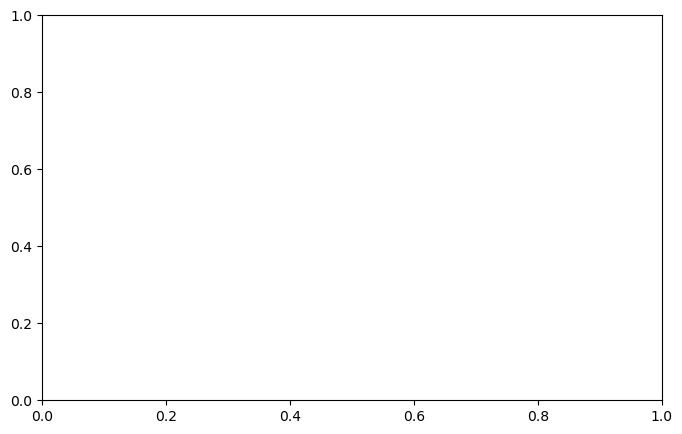

In [8]:
from matplotlib import pyplot as plt
import numpy as np
fig, ax = plt.subplots(figsize=(8,5))
plt.plot(train_losses)
plt.title('yolo model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.xticks(np.arange(0,20, step=1))
plt.legend(['train', 'test'], loc='upper right')
plt.show()